In [1]:
# Imports
import os 
from pathlib import Path
from itertools import count
from string import ascii_lowercase as alc

# Data processing
import xarray as xr
import numpy as np
import scipy.signal

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.ticker import AutoMinorLocator, FuncFormatter, MultipleLocator
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as PathEffects
from shapely.geometry import box, Polygon
import matplotlib.font_manager as fm

# Cartopy
import cartopy.crs as ccrs
import cartopy.feature

# Colour maps
import cmcrameri.cm as SCM

# Util
import ROME2024_cd_mechanism_util as util

In [2]:
sys_fonts = [fm.FontProperties(fname=font).get_name() for font in fm.findSystemFonts(fontpaths=None, fontext='ttf')]
if 'Inter' in sys_fonts:
    matplotlib.rcParams['font.sans-serif'] = 'Inter'

matplotlib.rcParams['font.family'] = "sans-serif"

# Simulated millennial-scale climate variability driven by a convection-advection oscillator

**Abstract**: The last glacial period, between $\sim$ 115 and 12 thousand years before present, exhibited strong millennial-scale climate variability. This includes abrupt transitions between cold and warm climates, known as Dansgaard-Oeschger (D-O) events. D-O events have been linked to switches in regimes of the Atlantic Overturning Meridional Circulation (AMOC), but the exact mechanisms behind abrupt climate changes and AMOC regimes switches remain poorly understood.

This paper introduces the convection-advection oscillator mechanism to explain the millennial-scale oscillations observed in a set of HadCM3 general circulation model simulations forced with snapshots of deglacial meltwater history. The oscillator can be separated into two components acting on different time scales. The fast convection component responds to changes in vertical stratification in the North Atlantic by activating or deactivating its deep water formation sites. The slow advection component regulates the accumulation and depletion of salinity in the North Atlantic.

The experiment indicates that this oscillator mechanism can only be triggered under specific background conditions and freshwater release combinations. The initial perturbation introduces an instability that triggers a global salt reorganisation, modifying the North Atlantic stratification. For a given configuration, the system oscillates if the salt redistribution can lead to both the reactivation and the deactivation of the AMOC. Otherwise, the climate settles in a warm or cold steady state. This new mechanism expands the existing millennial-scale variability theories and provides a general framework for understanding abrupt climate changes in general circulation models.

This notebook presents the code that was used to create Figures 1 to 3 and 5. 
You can save the Figures by uncommenting the cells at the end of each section.
This notebook used the Inter font that can be installed for free (https://fonts.google.com/specimen/Inter). You will need this to obtained the same versions than in the manuscript. Otherwise, your system's default sans-serif font will be used. 

## Global variables

In [3]:
# Define the script and output folders

script_folder = os.getcwd()
data_folder = f"{script_folder}/data"
output_folder = f"{script_folder}/Figures"


In [4]:
color_expts = {'xoupa':'black', 
              'xouph':'xkcd:bluey grey', 
              'xoupf':'xkcd:velvet', 
              'xoupk':'xkcd:bluish', 'tfgbi':'xkcd:bluish',
               'xppbe':'xkcd:purple',
               'xppbf':'xkcd:bluish green'}

label_expts = {'xoupa':'CTRL', 
               'xouph':'21k', 
               'tfgbi':'20.7k', 
               'xoupk':'20.7k_tdc', 
               'xoupf':'18.2k',
               'xppbe':'20.7k with 21k GST',
               'xppbf':'20.7_no_gst'}


In [5]:
color_zones = {'arc':'#A4D4D2',
               'na':'#00316A', 'ena':'xkcd:blue green', 'wna':'xkcd:navy', 
               'tpa':'#306B34', 
               'sa':'#CCB400', 
               'pac':'#B41001', 'npc':'xkcd:light red', 'spc':'xkcd:dark red',
               'idn':'#F68307', 
               'soa':'xkcd:wisteria', 'soi':'xkcd:pinky purple', 'sop':'xkcd:royal purple', 
               'so':'#953878', 
               'tot':'xkcd:black', 
               'gin':'#DFBA47', 'irm':'#CFABA0', 'ls':'#CC573D', 
               'spg':'#C4BE81', 'eur':'#9EA550'}

label_zones = {'arc':'Arctic', 
               'ena':'East North Atlantic', 'wna':'West North Atlantic', 
               'na': 'North Atlantic', 'tpa':'Subtropical Atlantic', 'sa':'South Atlantic',
               'pac':'Pacific', 'npc':'North Pacific', 'spc':'South Pacific',
               'idn':'Indian',
               'so':'Southern', 'soa':'SO Atlantic', 'soi':'SO Indian', 'sop':'SO Pacific', 
               'tot':'Total',
               'gin':'GIN Seas', 'irm':'Irminger Sea', 'ls':'Labrador Sea', 
               'spg':'Subpolar gyre', 'eur':'Iceland Basin'}


In [6]:
marker_depth = {'sfc':'^', 'int':'+', 'deep':'v', 'tot':''}
depth_label = {'sfc':'Upper\n<550m', 'int':'Intermediate\n550-1800m', 'deep':'Deep\n>1800m', 'tot':None}


In [7]:
color_spans = {'cold':'#484A6C', 
               'warming':'#FFABAB',
               'merid':'#C9381B', 
               'zonal':'#F59F00', 
               'cooling':'#B7DDF6'}

label_spans = {'warming':"Warming phase", 'cooling':"Cooling phase"}

In [8]:
filt = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)

## Data

### Zones

In [9]:
# Ocean masks - Global
ds_basin = xr.open_dataset(f"{data_folder}/inputs/basin_hadcm3_glac1d_lgm.nc")

masks = {}

masks['arc'] = ds_basin.arctic
masks['na'] = ds_basin.atlantic.sel(latitude=slice(44,79))
masks['tpa'] = ds_basin.atlantic.sel(latitude=slice(-33,44))
masks['sa'] = ds_basin.atlantic.sel(latitude=slice(-60,-33))
masks['pac'] = ds_basin.pacific
masks['so'] = ds_basin.southern
masks['idn'] = ds_basin.indian


In [10]:
# Ocean masks - North Atlantic

masks_na = {}

masks_na['gin'] = xr.concat([ds_basin.atlantic.sel(longitude=slice(340,360)).sel(latitude=slice(64,79)),
                          ds_basin.atlantic.sel(longitude=slice(0,20)).sel(latitude=slice(64,79))], 
                         dim='longitude')
masks_na['eur'] = xr.concat([ds_basin.atlantic.sel(longitude=slice(340,360)).sel(latitude=slice(44,64)),
                          ds_basin.atlantic.sel(longitude=slice(0,2)).sel(latitude=slice(44,64))], 
                         dim='longitude')
masks_na['irm'] = ds_basin.atlantic.sel(longitude=slice(316,339)).sel(latitude=slice(53,70))
masks_na['ls'] = ds_basin.atlantic.sel(longitude=slice(280,315)).sel(latitude=slice(53,79))
masks_na['spg'] = ds_basin.atlantic.sel(longitude=slice(280,339)).sel(latitude=slice(44,53))
masks_na['arc'] = ds_basin.arctic


In [11]:
masks_na_atm = {}

masks_na_atm['gin'] = masks_na['gin'].sel(
    longitude=masks_na['gin'].longitude[1::3]).assign_coords(
    latitude=masks_na['gin'].latitude+0.625).sel(
    latitude=masks_na['gin'].latitude[::2]+0.625)

masks_na_atm['irm'] = masks_na['irm'].sel(
    longitude=masks_na['irm'].longitude[2::3]).assign_coords(
    latitude=masks_na['irm'].latitude+0.625).sel(
    latitude=masks_na['irm'].latitude[1::2]+0.625)

masks_na_atm['eur'] = masks_na['eur'].sel(
    longitude=masks_na['eur'].longitude[1::3]).assign_coords(
    latitude=masks_na['eur'].latitude+0.625).sel(
    latitude=masks_na['eur'].latitude[::2]+0.625)


### Phase spans

In [12]:
span_regions = {}

span_regions['tfgbi']={'cold':Polygon([(18,30), (27,30), (27,40), (18,40)]), 
                       'merid':Polygon([(70,50), (95,50), (95,90), (75,90), (55,65)]), 
                       'zonal':Polygon([(30,65), (55,65), (75,90), (55,105), (30,105)]),
                       'warming':Polygon([(18,40), (27,40), (70,50), (55,65)]), 
                       'cooling':Polygon([(18,40), (27,40), (55,65), (30,65)])}

span_regions['xoupk']={'cold':Polygon([(18,30), (27,30), (27,40), (18,40)]), 
                       'merid':Polygon([(70,50), (100,50), (100,90), (75,90), (55,60)]), 
                       'zonal':Polygon([(30,65), (55,60), (75,90), (55,105), (30,105)]),
                       'warming':Polygon([(18,40), (27,40), (70,50), (55,60)]), 
                       'cooling':Polygon([(18,40), (27,40), (55,60), (30,65)])}

span_regions['xouph']={'cold':box(35,40,45,55), 
                       'warming':box(35,55,52,67), 
                       'merid':box(0,0,0,0), 
                       'zonal':box(35,67,52,95),
                       'cooling':box(35,55,52,67)}

span_regions['xoupf']={'cold':box(10,25,25,55), 
                       'warming':box(25,30,45,55), 
                       'merid':box(45,30,95,55), 
                       'zonal':box(0,0,0,0), 
                       'cooling':box(25,30,45,55)}


In [13]:
span_conditions, spans = {}, {}

for expt in ['tfgbi', 'xoupf', 'xouph', 'xoupk', 'xppbf']:
    span_conditions[expt], spans[expt] = {}, {}

    for phase in ['cold', 'warming', 'merid', 'zonal', 'cooling']:
        span_conditions[expt][phase] = np.genfromtxt(f"{data_folder}/{expt}/spans/{expt}.span_conditions.{phase}.csv", delimiter=',')
        
        spans[expt][phase] = np.atleast_2d(
            np.genfromtxt(f"{data_folder}/{expt}/spans/{expt}.spans.{phase}.csv", delimiter=','))

## Figure 1 - Anatomy of the oscillations

In [14]:
amoc_ts = {}
amocf_ts = {}

for expt in ['tfgbi']:
    ts = xr.open_dataset(f"{data_folder}/{expt}/{expt}.merid.annual.nc")
    amoc_ts[expt] = ts.Merid_Atlantic.sel(latitude=26.5, method='nearest').max('depth').sortby('t')
    amocf_ts[expt] = filt.process(amoc_ts[expt].values)
    

In [15]:
mld_zone, mldf_zone = {}, {}

for expt in ['tfgbi']:
    mld_zone[expt], mldf_zone[expt] = {}, {}
    temp_mld = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.mld.zone_na.annual.nc").mld

    for zone in masks_na.keys():
        mld_zone[expt][zone] = temp_mld.sel(zone=zone)[1:]
        mldf_zone[expt][zone] = filt.process(mld_zone[expt][zone].values)

In [16]:
mld = {}
mld_phase = {}

for expt in ['tfgbi']:
    mld_phase[expt] = {}
    mld[expt] = xr.open_dataset(f"{data_folder}/{expt}/{expt}.oceanmixedpf.annual.nc").mixLyrDpth_mm_uo.isel(
        unspecified=0, drop=True)[1:]

    for phase in ['cold', 'merid', 'zonal']:
        if np.any(spans[expt][phase]):
            mld_phase[expt][phase] = xr.concat(
                [mld[expt].isel(t=slice(*span)) for span in spans[expt][phase].astype(int)], dim='t').mean('t')


In [17]:
cmap_amoc = LinearSegmentedColormap.from_list('magma', matplotlib.colormaps['magma'](np.linspace(0, 0.9, 256)))
                                              
def plot_LineCollection(ax, x, y, alpha, lw, cm):
    points = np.array([x, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cm, linewidth=lw, alpha=alpha)
    lc.set_array(y)

    ax.add_collection(lc)
    

Text(0.02, 0.95, 'b')

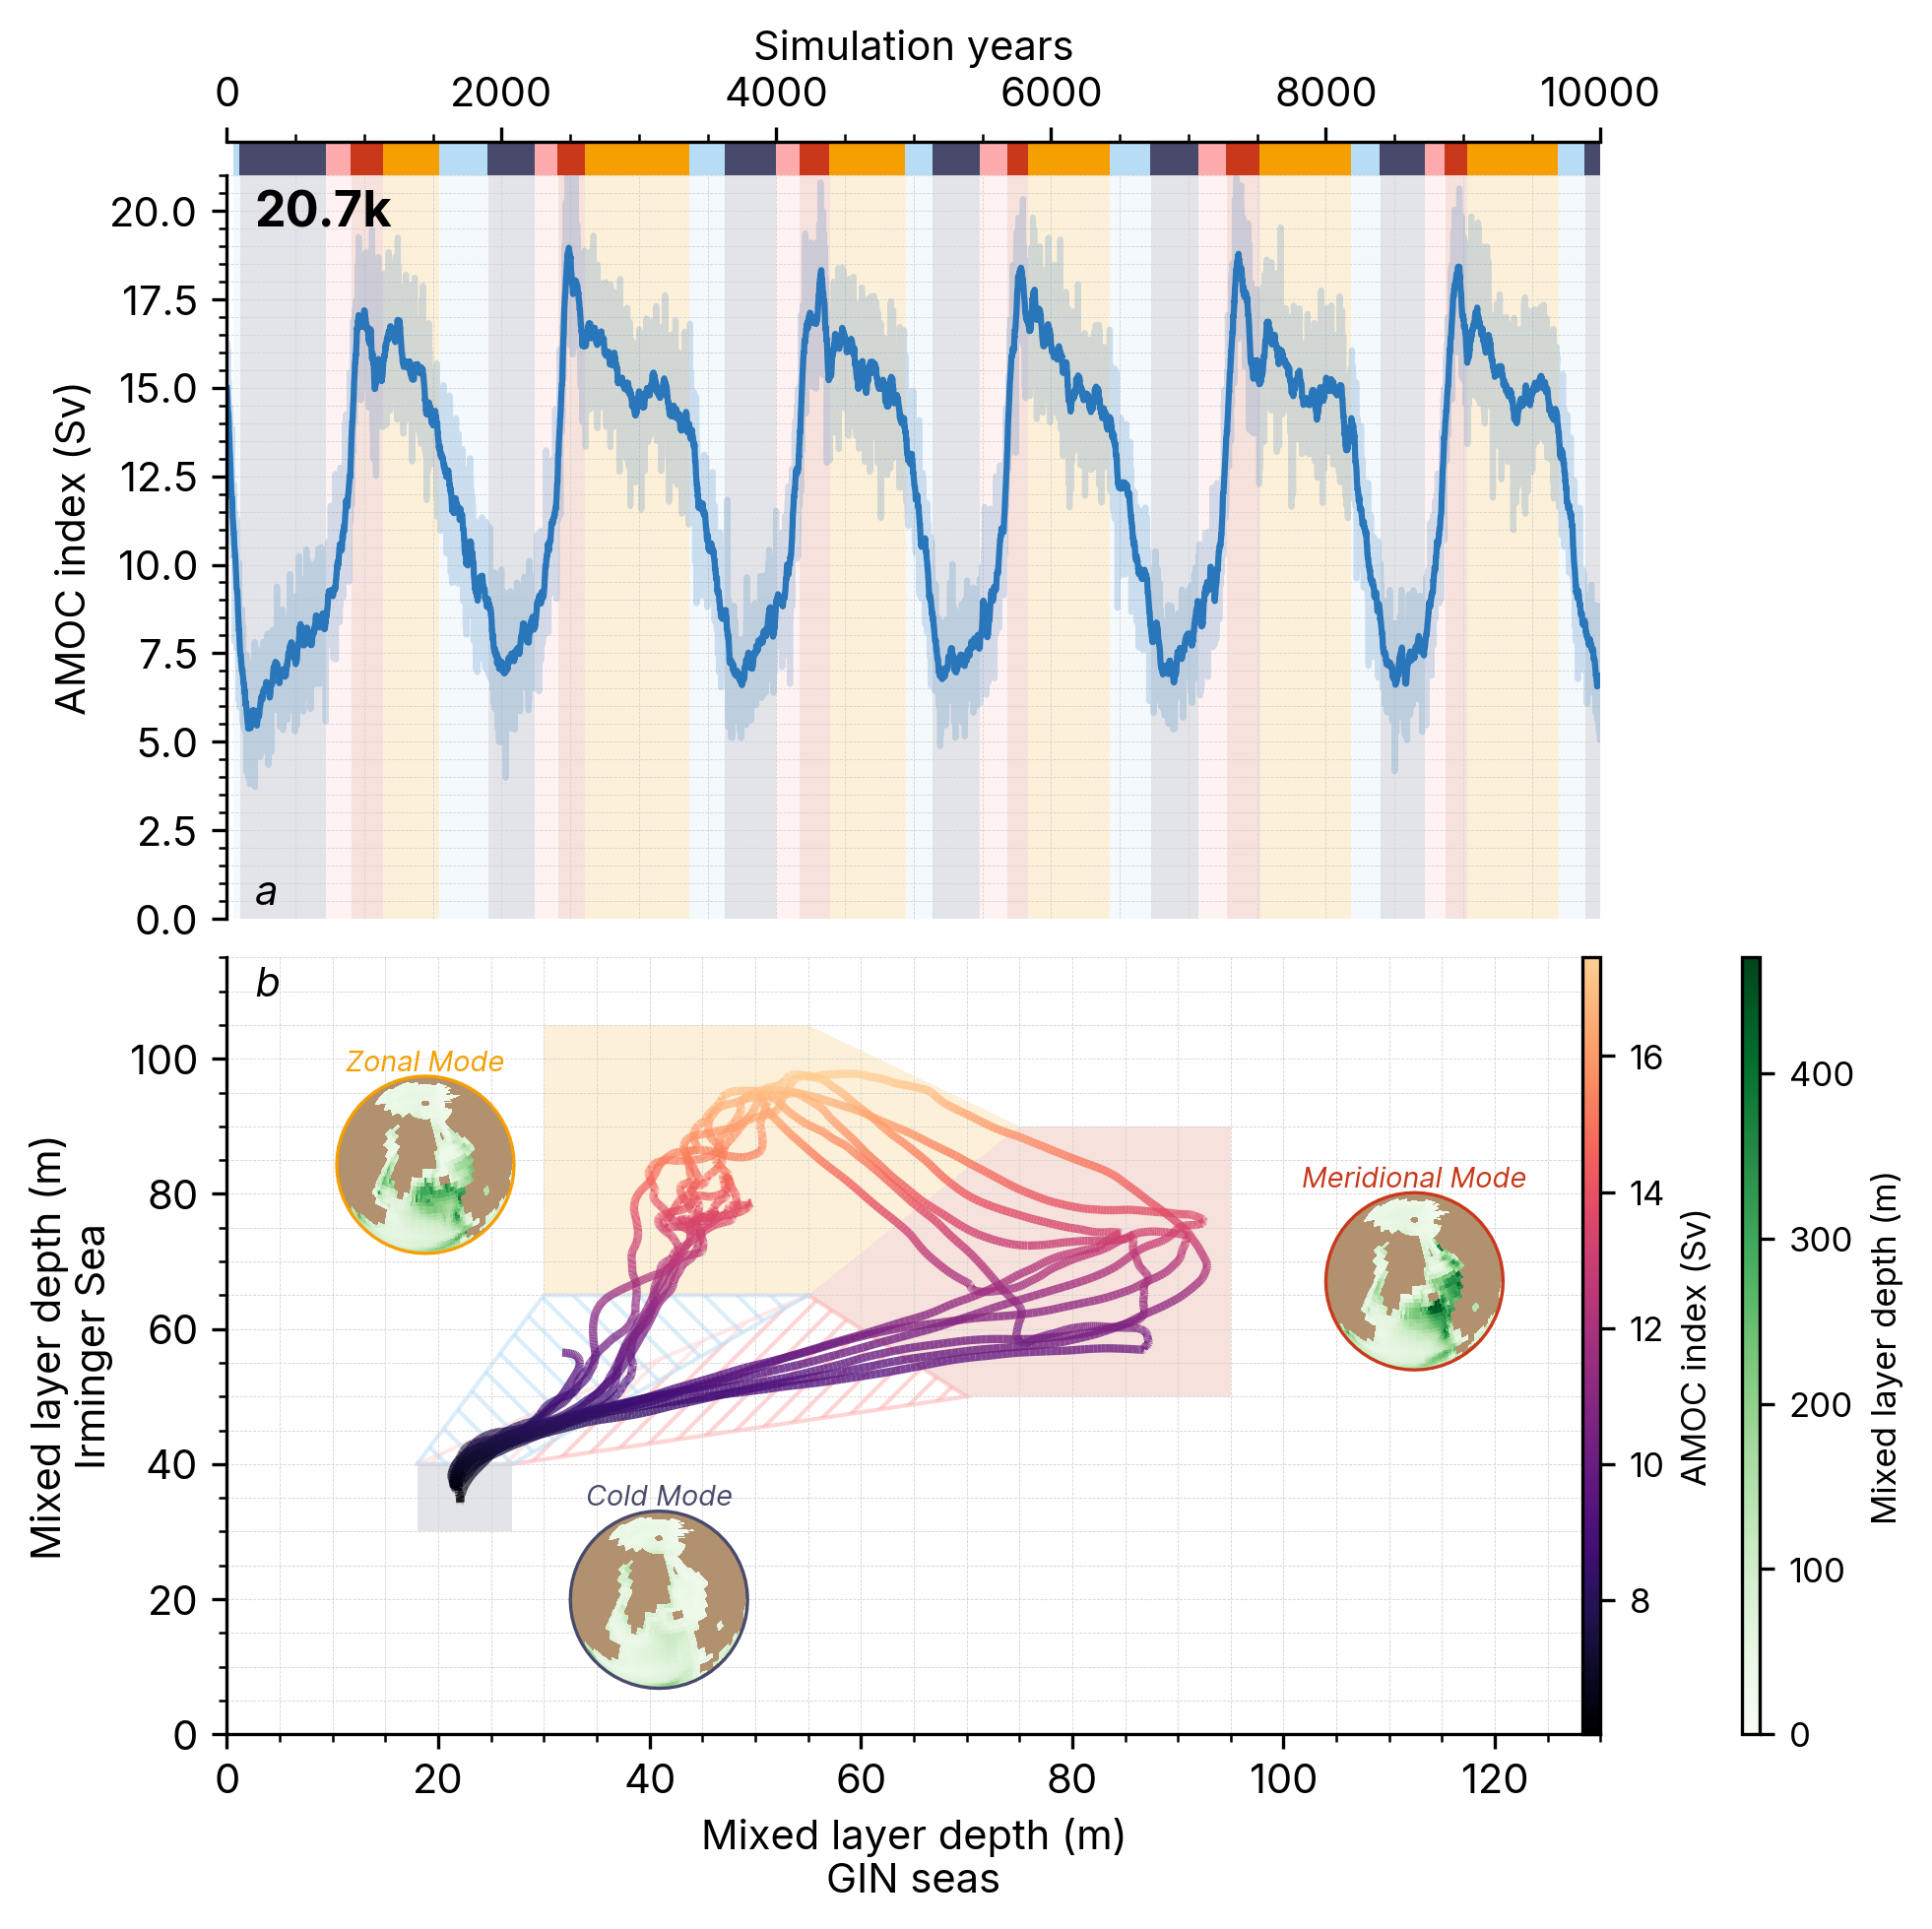

In [18]:
fig = plt.figure(figsize=(6, 7), dpi=300)

grid = fig.add_gridspec(2, 1, hspace=0.05)
grid_ts = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[0], height_ratios=[1,10],
                                           wspace=0.1, hspace=-0.1)
grid_mld = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1], wspace=0.1)

expt_osc = 'tfgbi'
axSPAN, axAMOC, axMLD = {}, {}, {}
axSPAN = {expt_osc:fig.add_subplot(grid_ts[0,0])}
axAMOC[expt_osc] = fig.add_subplot(grid_ts[1,0], sharex=axSPAN[expt_osc])
axMLD[expt_osc] = fig.add_subplot(grid_mld[0,0])

fig.subplots_adjust(wspace=0.1)

projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=70, satellite_height=3000000)

time = {}
cax_hist = {}


# Plots
for expt in axAMOC.keys():
    time[expt] = amoc_ts[expt].t.dt.year-1000
    
    # Plot spans and overlay
    for phase in spans[expt].keys():
        axSPAN[expt].imshow(np.expand_dims(span_conditions[expt][phase], axis=0), aspect='auto',
                            cmap = ListedColormap(['None', color_spans[phase]]))

        for span in spans[expt][phase]:
            axAMOC[expt].axvspan(span[0], span[1], alpha=0.15, linewidth=0, color=color_spans[phase])
    
    #Plot AMOC
    axAMOC[expt].plot(amoc_ts[expt].t.dt.year-1000, util.rmean(amoc_ts[expt],30), color=color_expts[expt])
    axAMOC[expt].plot(amoc_ts[expt].t.dt.year-1000, amoc_ts[expt], color=color_expts[expt], alpha=0.2)
    
        
    # Plot MLD phase
    plot_LineCollection(axMLD[expt],mldf_zone[expt]['gin'], mldf_zone[expt]['irm'], alpha=0.8, lw=2, cm=cmap_amoc)


    # Add phases ax_boxes
    for phase in ['cold', 'merid', 'zonal']:
        axMLD[expt].fill(*span_regions[expt][phase].exterior.xy, facecolor=color_spans[phase], alpha=0.15)  
    axMLD[expt].fill(*span_regions[expt]['warming'].exterior.xy, facecolor='white', alpha=0.5, 
                     hatch="////", edgecolor=color_spans['warming'])
    axMLD[expt].fill(*span_regions[expt]['cooling'].exterior.xy, facecolor='white', alpha=0.5, 
                     hatch="\\\\\\", edgecolor=color_spans['cooling'])
plt.rcParams['hatch.linewidth'] = 1


# Plot AMOC colorbar
mappable = ScalarMappable()
mappable.set_array(amocf_ts[expt])
mappable.set_cmap(cmap_amoc)
cax = fig.add_axes([axMLD[expt].get_position().x1-0.01,axMLD[expt].get_position().y0,
                    0.01, axMLD[expt].get_position().height])
cb = plt.colorbar(mappable, cax=cax)
cb.set_label(f"AMOC index (Sv)", size='small')
cb.ax.tick_params(labelsize='small')


# Adding Maps
norm = Normalize(vmin=0, vmax=300)
width, height = 0.1, 0.1

ax_box = axMLD[expt_osc].get_position()

ax = fig.add_axes([ax_box.x0 + ax_box.width*0.25, ax_box.y0 + ax_box.height*0.04, width, height],
                  projection=projection_map, facecolor='xkcd:pale brown')
ax.spines['geo'].set_edgecolor(color_spans['cold']) 
ax.pcolormesh(mld_phase[expt_osc]['cold'].longitude, mld_phase[expt_osc]['cold'].latitude,
              np.where(mld_phase[expt_osc]['cold']==0, np.nan, mld_phase[expt_osc]['cold']),
              cmap='Greens', norm=norm, transform=ccrs.PlateCarree())
ax.set_title("Cold Mode", fontsize='x-small', color=color_spans['cold'], fontstyle='italic', pad=0.5)

ax = fig.add_axes([ax_box.x0 + ax_box.width*0.8, ax_box.y0 + ax_box.height*0.45, width, height],
                  projection=projection_map, facecolor='xkcd:pale brown')
ax.spines['geo'].set_edgecolor(color_spans['merid']) 
ax.pcolormesh(mld_phase[expt_osc]['merid'].longitude, mld_phase[expt_osc]['merid'].latitude,
              np.where(mld_phase[expt_osc]['merid']==0, np.nan, mld_phase[expt_osc]['merid']),
              cmap='Greens', norm=norm, transform=ccrs.PlateCarree())
ax.set_title("Meridional Mode", fontsize='x-small', color=color_spans['merid'], fontstyle='italic', pad=0.5)

ax = fig.add_axes([ax_box.x0 + ax_box.width*0.08, ax_box.y0 + ax_box.height*0.6,
                   width, height],
                  projection=projection_map, facecolor='xkcd:pale brown')
ax.spines['geo'].set_edgecolor(color_spans['zonal']) 
ax.pcolormesh(mld_phase[expt_osc]['zonal'].longitude, mld_phase[expt_osc]['zonal'].latitude,
              np.where(mld_phase[expt_osc]['zonal']==0, np.nan, mld_phase[expt_osc]['zonal']),
              cmap='Greens', norm=norm, transform=ccrs.PlateCarree())
ax.set_title("Zonal Mode", fontsize='x-small', color=color_spans['zonal'], fontstyle='italic', pad=0.5)


# Plot MLD colorbar
mappable = ScalarMappable()
mappable.set_array(mld_phase[expt_osc]['merid'])
mappable.set_cmap('Greens')
cax = fig.add_axes([axMLD[expt].get_position().x1+0.08,axMLD[expt].get_position().y0,
                    0.01, axMLD[expt].get_position().height])
cb = plt.colorbar(mappable, cax=cax)
cb.set_label(f"Mixed layer depth (m)", size='small')
cb.ax.tick_params(labelsize='small')


# Span parameters
for ax in axSPAN.values():
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')    
    ax.yaxis.set_visible(False)
    for loc in ['left', 'right', 'bottom']:ax.spines[loc].set_visible(False)
    ax.set_xlim([0,10000])
    ax.set_xlabel("Simulation years")

        
# AMOC time series parameters
for ax in axAMOC.values(): 
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['right', 'top', 'bottom']:ax.spines[loc].set_visible(False)
    ax.set_ylim([0,21])
axAMOC[expt_osc].set_ylabel("AMOC index (Sv)")


# Phase parameters
for ax in axMLD.values(): 
    ax.set_xlim([0,130])
    ax.set_ylim([0,115])
    for loc in ['right', 'top']:ax.spines[loc].set_visible(False)
    ax.set_xlabel('Mixed layer depth (m)\nGIN seas')
axMLD[expt_osc].set_ylabel('Mixed layer depth (m)\nIrminger Sea')


# Time series parameters
for ax in np.array([list(axAMOC.values()), list(axMLD.values())]).flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='both', color='lightgrey', linestyle='--', linewidth=0.2, zorder=0)

    
# Annotations

# Add expt name to AMOC pannels
for expt in axAMOC.keys():
    txt = axAMOC[expt].annotate(f"{label_expts[expt]}", xy=(0.02, 0.95),
                                xycoords='axes fraction',
                                size='large', va='center', ha='left', color='black', 
                                weight='bold')

axAMOC['tfgbi'].annotate('a', xy=(0.02,0.02), xycoords='axes fraction',
                         size=10, style='italic')
axMLD['tfgbi'].annotate('b', xy=(0.02,0.95), xycoords='axes fraction', 
                        size=10, style='italic')


In [19]:
# fig.savefig(f"{output_folder}/main/anatomy.png", bbox_extra_artists=(), bbox_inches='tight', format='png')
# fig.savefig(f"{output_folder}/main/anatomy.pdf", bbox_extra_artists=(), bbox_inches='tight', format='pdf')

## Figure 2 - North Altantic

In [20]:
expt='tfgbi'

In [21]:
# Sea Ice

ds_wice = xr.open_dataset(f"{data_folder}/{expt}/{expt}.iceconc.mr.nc").iceconc_mm_srf.isel(surface=0)
ds_sice = xr.open_dataset(f"{data_folder}/{expt}/{expt}.iceconc.sp.nc").iceconc_mm_srf.isel(surface=0)

wice, sice = {}, {}

for zone in masks_na_atm.keys():
    print(f"__Processing {zone}")
    wice[zone] = (ds_wice*masks_na_atm[zone]).mean(
        dim=['longitude', 'latitude'])*100
    sice[zone] = (ds_sice*masks_na_atm[zone]).mean(
        dim=['longitude', 'latitude'])*100
    

__Processing gin
__Processing irm
__Processing eur


In [22]:
# Ice area
wice_area = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.ice_area.zone_na.mr.nc").ice_area
sice_area = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.ice_area.zone_na.sp.nc").ice_area


In [23]:
# MLD

mld_zone = {}
temp_mld = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.mld.zone_na.annual.nc").mld
    
for zone in masks_na.keys():
    mld_zone[zone] = temp_mld.sel(zone=zone)[1:]


In [24]:
# Streamfunction

stream_zone = {}
temp_stream = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.stream.zone_na.annual.nc").stream
    
for zone in masks_na.keys():
    stream_zone[zone] = -temp_stream.sel(zone=zone)[1:]


In [25]:
# Profiles

ocnt_mean = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.temperature_means.zone_na.annual.nc").temperature_means
ocns_mean = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.salinity_means.zone_na.annual.nc").salinity_means
ocnd_mean = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.density_means.zone_na.annual.nc").density_means


In [26]:
# color_mld = 'xkcd:emerald'
color_mld = 'black'
# color_spg = '#561643'
color_spg = 'black'
color_wice = 'xkcd:dark teal'
color_sice = 'xkcd:brick red'
color_T = '#8C4040'
color_S = '#2B344F'
color_D = '#0F3210'

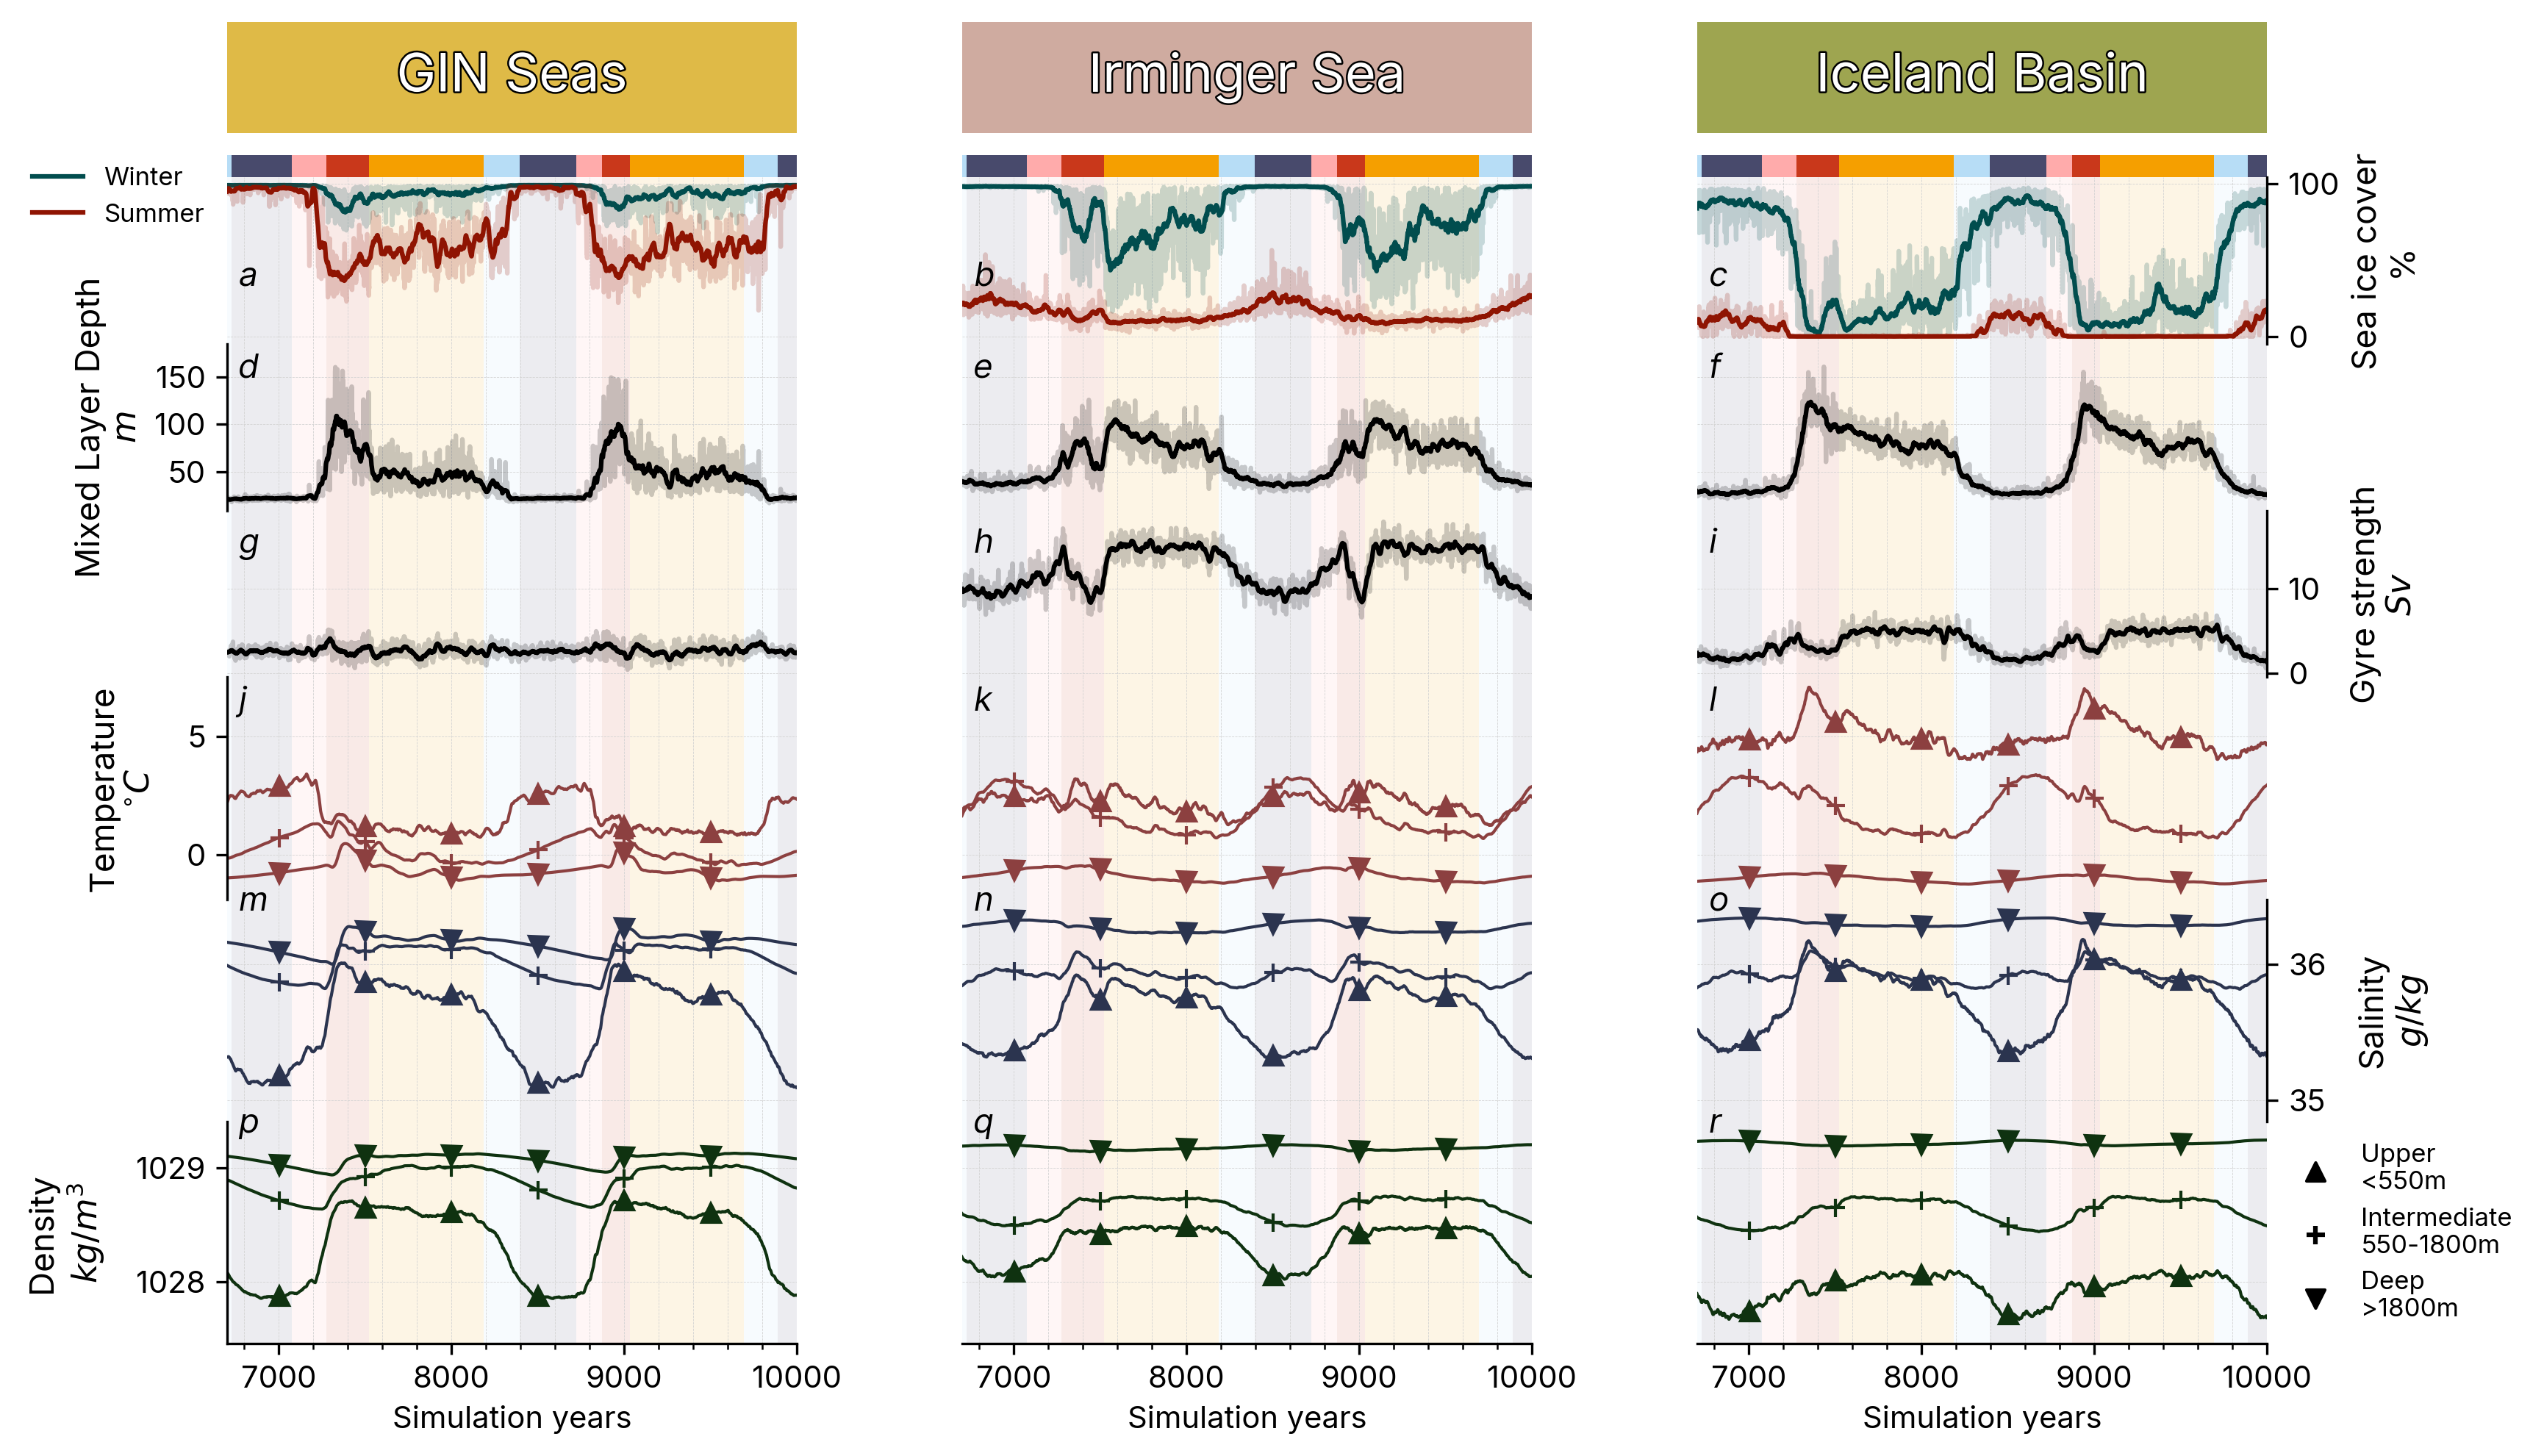

In [27]:
fig = plt.figure(figsize=(10, 7), dpi=300)

zones = ['gin', 'irm', 'eur']
subfigs = fig.subfigures(1, 3)

grid_zone, grid_ts = {}, {}
axSPANSts, axICE, axMLD, axSTREAM, axT, axS, axD = {}, {}, {}, {}, {}, {}, {}

iterator = count(0)

for zone in zones:
    i = next(iterator)
    
    # Grid Surface
    grid_ts[zone] = subfigs[i].add_gridspec(7, 1, hspace=0, height_ratios=[2,15,15,15,20,20,20])
    
    axSPANSts[zone] = subfigs[i].add_subplot(grid_ts[zone][0])
    if zone==zones[0]:
        axICE[zone] = subfigs[i].add_subplot(grid_ts[zone][1], sharex=axSPANSts[zone], facecolor='None')
        axMLD[zone] = subfigs[i].add_subplot(grid_ts[zone][2], sharex=axSPANSts[zone], facecolor='None')
        axSTREAM[zone] = subfigs[i].add_subplot(grid_ts[zone][3], sharex=axSPANSts[zone], facecolor='None')
        axT[zone] = subfigs[i].add_subplot(grid_ts[zone][4], sharex=axSPANSts[zone], facecolor='None')
        axS[zone] = subfigs[i].add_subplot(grid_ts[zone][5], sharex=axSPANSts[zone], facecolor='None')
        axD[zone] = subfigs[i].add_subplot(grid_ts[zone][6], sharex=axSPANSts[zone], facecolor='None')
    else:
        axICE[zone] = subfigs[i].add_subplot(grid_ts[zone][1], sharex=axSPANSts[zone], sharey=axICE[zones[0]], facecolor='None')
        axMLD[zone] = subfigs[i].add_subplot(grid_ts[zone][2], sharex=axSPANSts[zone], sharey=axMLD[zones[0]], facecolor='None')
        axSTREAM[zone] = subfigs[i].add_subplot(grid_ts[zone][3], sharex=axSPANSts[zone], sharey=axSTREAM[zones[0]], facecolor='None')
        axT[zone] = subfigs[i].add_subplot(grid_ts[zone][4], sharex=axSPANSts[zone], sharey=axT[zones[0]], facecolor='None')
        axS[zone] = subfigs[i].add_subplot(grid_ts[zone][5], sharex=axSPANSts[zone], sharey=axS[zones[0]], facecolor='None')
        axD[zone] = subfigs[i].add_subplot(grid_ts[zone][6], sharex=axSPANSts[zone], sharey=axD[zones[0]], facecolor='None')



    
    # Plot TS
    # Spans
    for phase in spans[expt].keys():
        for span in spans[expt][phase]:
            axSPANSts[zone].axvspan(span[0], span[1], alpha=1, linewidth=0, color=color_spans[phase])

    # Sea ice
    axICE[zone].plot(wice[zone].t.dt.year-1000, util.rmean(wice[zone],30), color=color_wice, label='Winter')
    axICE[zone].plot(wice[zone].t.dt.year-1000, wice[zone], color=color_wice, alpha=0.2)
    axICE[zone].plot(sice[zone].t.dt.year-1000, util.rmean(sice[zone],30), color=color_sice, label='Summer')
    axICE[zone].plot(sice[zone].t.dt.year-1000, sice[zone], color=color_sice, alpha=0.2)

    # MLD
    axMLD[zone].plot(mld_zone[zone].t.dt.year-1000, util.rmean(mld_zone[zone],30), color=color_mld)
    axMLD[zone].plot(mld_zone[zone].t.dt.year-1000, mld_zone[zone], color=color_mld, alpha=0.2)

    # Streamfunction
    axSTREAM[zone].plot(stream_zone[zone].t.dt.year-1000, util.rmean(stream_zone[zone],30)*1e-12, color=color_spg)
    axSTREAM[zone].plot(stream_zone[zone].t.dt.year-1000, stream_zone[zone]*1e-12, color=color_spg, alpha=0.2)


    # Plot Temperatures
    for depth in ['sfc','int','deep']:
        axT[zone].plot(ocnt_mean.t.dt.year-1000, util.rmean(ocnt_mean.sel(depth=depth).sel(zone=zone), 30), 
                       color=color_T, linewidth=1)
        axT[zone].plot(ocnt_mean.t.dt.year[::500]-1000, util.rmean(ocnt_mean.sel(depth=depth).sel(zone=zone), 30)[::500], 
                       color=color_T, lw=0,marker=marker_depth[depth])

    # Plot Density
    for depth in ['sfc','int','deep']:
        axS[zone].plot(ocns_mean.t.dt.year-1000, util.rmean(ocns_mean.sel(depth=depth).sel(zone=zone), 30),
                       color=color_S, linewidth=1)
        axS[zone].plot(ocns_mean.t.dt.year[::500]-1000, util.rmean(ocns_mean.sel(depth=depth).sel(zone=zone), 30)[::500], 
                       color=color_S, lw=0,marker=marker_depth[depth])

    # Plot Density
    for depth in ['sfc','int','deep']:
        axD[zone].plot(ocnd_mean.t.dt.year-1000, util.rmean(ocnd_mean.sel(depth=depth).sel(zone=zone), 30),
                       color=color_D, linewidth=1)
        axD[zone].plot(ocnd_mean.t.dt.year[::500]-1000, util.rmean(ocnd_mean.sel(depth=depth).sel(zone=zone), 30)[::500], 
                       color=color_D, lw=0,marker=marker_depth[depth])


    # Zone titles
    ax_box = axSPANSts[zone].get_position()

    cax = subfigs[i].add_axes([ax_box.x0, ax_box.y1 + ax_box.height,
                        ax_box.width, 
                        5*ax_box.height])

    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    for loc in ['left', 'right', 'bottom', 'top']: cax.spines[loc].set_visible(False)
    cax.set_facecolor(color_zones[zone])

    txt = cax.annotate(label_zones[zone], 
                       xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center',
                       size='xx-large', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.2, foreground='black')])

    
# Spans Overlay
for ax in np.array([list(axICE.values()), list(axMLD.values()), list(axSTREAM.values()),
                    list(axT.values()), list(axS.values()), list(axD.values())]).flat:
    for phase in spans[expt].keys():
        for span in spans[expt][phase]:
            ax.axvspan(span[0], span[1], alpha=0.1, linewidth=0, color=color_spans[phase])


# TS parameters
for ax in np.array([list(axICE.values()), list(axMLD.values()), list(axSTREAM.values()), 
                    list(axT.values()), list(axS.values()), list(axD.values())]).flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.2)


    
# Spans parameters
for ax in axSPANSts.values():
    ax.tick_params(axis='x', colors='None', which='both')
    ax.yaxis.set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlim([6700,10000])
    for loc in ['left', 'right', 'bottom', 'top']:ax.spines[loc].set_visible(False)

        
# Sea Ice parameters
for ax in axICE.values():
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['left', 'top', 'bottom']:ax.spines[loc].set_visible(False)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')    
for zone in ['gin','irm']:
    axICE[zone].tick_params(axis='y', colors='None', which='both')
    axICE[zone].spines['right'].set_visible(False)
axICE['eur'].set_ylabel("Sea ice cover\n"r"%", size=11, color='black')
axICE['gin'].legend(fontsize="small", bbox_to_anchor=(0,1.2), loc='upper right', frameon=False)
     
    
# MLD parameters
for ax in axMLD.values():
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['right', 'top', 'bottom']:ax.spines[loc].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')    
    ax.spines['left'].set_color(color_mld)
    ax.tick_params(axis='y', colors=color_mld)    
for zone in ['irm','eur']:
    axMLD[zone].tick_params(axis='y', colors='None', which='both')
    axMLD[zone].spines['left'].set_visible(False)
axMLD['gin'].set_ylabel("Mixed Layer Depth\n"r"$m$", size=11, color=color_mld)

# Stream parameters
for ax in axSTREAM.values():
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['left', 'top', 'bottom']:ax.spines[loc].set_visible(False)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')    
    ax.spines['right'].set_color(color_spg)
    ax.tick_params(axis='y', colors=color_spg)    
for zone in ['gin','irm']:
    axSTREAM[zone].tick_params(axis='y', colors='None', which='both')
    axSTREAM[zone].spines['right'].set_visible(False)
axSTREAM['eur'].set_ylabel("Gyre strength\n""$Sv$", size=11, color=color_spg, labelpad=10)

# Temperature parameters
for ax in axT.values(): 
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['right', 'top', 'bottom']:ax.spines[loc].set_visible(False)
for zone in ['irm','eur']:
    axT[zone].tick_params(axis='y', colors='None', which='both')
    axT[zone].spines['left'].set_visible(False)
axT['gin'].set_ylabel("Temperature\n"r"$^{\circ}C$", size=11, labelpad=10)

# Salinity parameters
for ax in axS.values(): 
    ax.tick_params(axis='x', colors='None', which='both')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')    
    for loc in ['left', 'top', 'bottom']:ax.spines[loc].set_visible(False)
for zone in ['gin','irm']:
    axS[zone].tick_params(axis='y', colors='None', which='both')
    axS[zone].spines['right'].set_visible(False)
axS['eur'].set_ylabel("Salinity\n"r"$g/kg$", size=11, labelpad=10)

# Density parameters
for ax in axD.values(): 
    ax.set_xlabel("Simulation years")
    for loc in ['right', 'top']:ax.spines[loc].set_visible(False)
for zone in ['irm','eur']:
    axD[zone].tick_params(axis='y', colors='None', which='both')
    axD[zone].spines['left'].set_visible(False)

axD['gin'].set_ylabel("Density\n"r"$kg/m^{3}$", size=11, labelpad=10)

markers = []
for marker in marker_depth.keys():
    if marker != 'tot':
        markers.append(axD['eur'].scatter([],[],
                marker = marker_depth[marker], label=depth_label[marker],
                color='black'))
    
lgD = axD['eur'].legend(handles=markers, fontsize="small", bbox_to_anchor=(1,0.5), loc='center left', frameon=False)



# Annotations

i = count(0)
for zone in zones:
    axICE[zone].annotate(alc[next(i)], xy=(0.02,0.35), xycoords='axes fraction',
                         size=11, style='italic')
for zone in zones:
    axMLD[zone].annotate(alc[next(i)], xy=(0.02,0.8), xycoords='axes fraction',
                         size=11, style='italic')
for zone in zones:
    axSTREAM[zone].annotate(alc[next(i)], xy=(0.02,0.75), xycoords='axes fraction',
                         size=11, style='italic')
for zone in zones:
    axT[zone].annotate(alc[next(i)], xy=(0.02,0.85), xycoords='axes fraction',
                         size=11, style='italic')
for zone in zones:
    axS[zone].annotate(alc[next(i)], xy=(0.02,0.95), xycoords='axes fraction',
                         size=11, style='italic')
for zone in zones:
    axD[zone].annotate(alc[next(i)], xy=(0.02,0.95), xycoords='axes fraction',
                         size=11, style='italic')


In [28]:
# fig.savefig(f"{output_folder}/main/na.png", bbox_extra_artists=([lgD]), bbox_inches='tight', format='png')
# fig.savefig(f"{output_folder}/main/na.pdf", bbox_extra_artists=([lgD]), bbox_inches='tight', format='pdf')

## Figure 3 - Inter-basin transfer of salt

In [29]:
salinity_clusters = {}

for expt in ['xoupa', 'tfgbi']: 
    salinity_clusters[expt] = xr.open_dataset(f"{data_folder}/{expt}/salinity_budgets/{expt}.salinity_clusters.decadal.nc").salinity_cluster

In [30]:
salinity_clusters_n = {}

for expt in ['tfgbi']:
    salinity_clusters_n[expt] = salinity_clusters[expt] - salinity_clusters[expt].mean(dim=['t'])


In [31]:
salinity_means = {}
for expt in ['xoupa', 'tfgbi']:
    salinity_means[expt] = xr.open_dataset(f"{data_folder}/{expt}/salinity_budgets/{expt}.salinity_means.decadal.nc").salinity_means
    

In [32]:
spans_color_list = {}

for expt in ['tfgbi',]:
    spans_color_list[expt] = {}

    spans_color_list[expt] = ['None']*len(span_conditions[expt]['cold'])

    for phase in spans[expt].keys():
        for span in spans[expt][phase].astype(int):
            spans_color_list[expt][span[0]:span[1]] = [color_spans[phase]]*(span[1]-span[0])


In [33]:
amoc_ts, amocf_ts = {}, {}
amoc_ts_n, amocf_ts_n = {}, {}

for expt in ['tfgbi']:
    ts = xr.open_dataset(f"{data_folder}/{expt}/{expt}.merid.annual.nc")
    amoc_ts[expt] = ts.Merid_Atlantic.sel(latitude=26.5, method='nearest').max('depth').sortby('t')
    amocf_ts[expt] = filt.process(amoc_ts[expt].values)

    amoc_ts_n[expt] = amoc_ts[expt] - np.mean(amoc_ts[expt])
    amocf_ts_n[expt] = amocf_ts[expt] - np.mean(amocf_ts[expt])


In [34]:
cross_correlation = {}
phases = {}
year_lags = scipy.signal.correlation_lags(len(amocf_ts['tfgbi'][::10]),
                                           len(salinity_clusters['tfgbi'].sel(zone='na').sel(depth='tot')))

for expt in ['tfgbi']:
    cross_correlation[expt] = {}
    phases[expt] = {}
    for zone in ['arc', 'na', 'tpa', 'sa', 'pac', 'idn', 'so']:
        cross_correlation[expt][zone] = {}
        phases[expt][zone] = {}
        for depth in ['sfc', 'int', 'deep','tot']:
            norm_factor = (len(amocf_ts_n['tfgbi']) * 
                           np.std(amocf_ts_n['tfgbi']) * 
                           np.std(salinity_clusters['tfgbi'].sel(zone=zone).sel(depth=depth))).values
            cross_correlation[expt][zone][depth] = scipy.signal.correlate(
                amocf_ts_n['tfgbi'][::10], salinity_clusters_n['tfgbi'].sel(
                    zone=zone).sel(depth=depth).values)/norm_factor

            phases[expt][zone][depth] = year_lags[
                np.argmax(cross_correlation[expt][zone][depth][
                    900:1100])+900]
            

In [35]:
cluster_zones = {
    'sna':[('na','sfc'), ('na','int'), ('arc','sfc')],
    'sta':[('tpa','sfc'), ('sa','sfc'), ('na','deep'), ('tpa','int'), ('tpa','deep'),
           ('pac','sfc'), ('idn','sfc')],
    'dpc':[('pac','deep'), ('sa', 'deep'), ('idn','deep'), ('so','deep')],
    'iid':[('idn','int'), ('sa','int'), ('arc','int'), ('pac','int'), ('so','sfc'), ('so','int'), ('arc','deep')],
}

cluster_name = {'sna':'North Atlantic waters', 'sta':'Subtropical waters',
                'dpc':'Deep waters', 'iid':'Intermediate waters'}
    
primary_cluster = {'sna':[('na', 'tot'), ('arc','tot')], 
                   'sta':[('tpa', 'tot')],
                   'dpc':[('pac', 'tot'), ('so','tot')]
                  }
secondary_cluster = {'sna':[('na', 'sfc'), ('arc','sfc')], 
                     'sta':[('tpa', 'sfc'), ('tpa','deep'), ('na','deep'), ('sa','sfc'), ('pac','sfc')],
                     'dpc':[('pac', 'int'), ('pac', 'deep'), ('so','int'), ('sa','tot')], 
                    }


In [36]:
color_text = {'arc':'#66B7B4',
               'na':'#00316A', 'ena':'xkcd:blue green', 'wna':'xkcd:navy', 
               'tpa':'#306B34', 
               'sa':'#CCB400', 
               'pac':'#B41001', 'npc':'xkcd:light red', 'spc':'xkcd:dark red',
               'idn':'#F68307', 
               'soa':'xkcd:wisteria', 'soi':'xkcd:pinky purple', 'sop':'xkcd:royal purple', 
               'so':'#953878', 
               'tot':'xkcd:black'}


Text(0.02, 0.92, 'e')

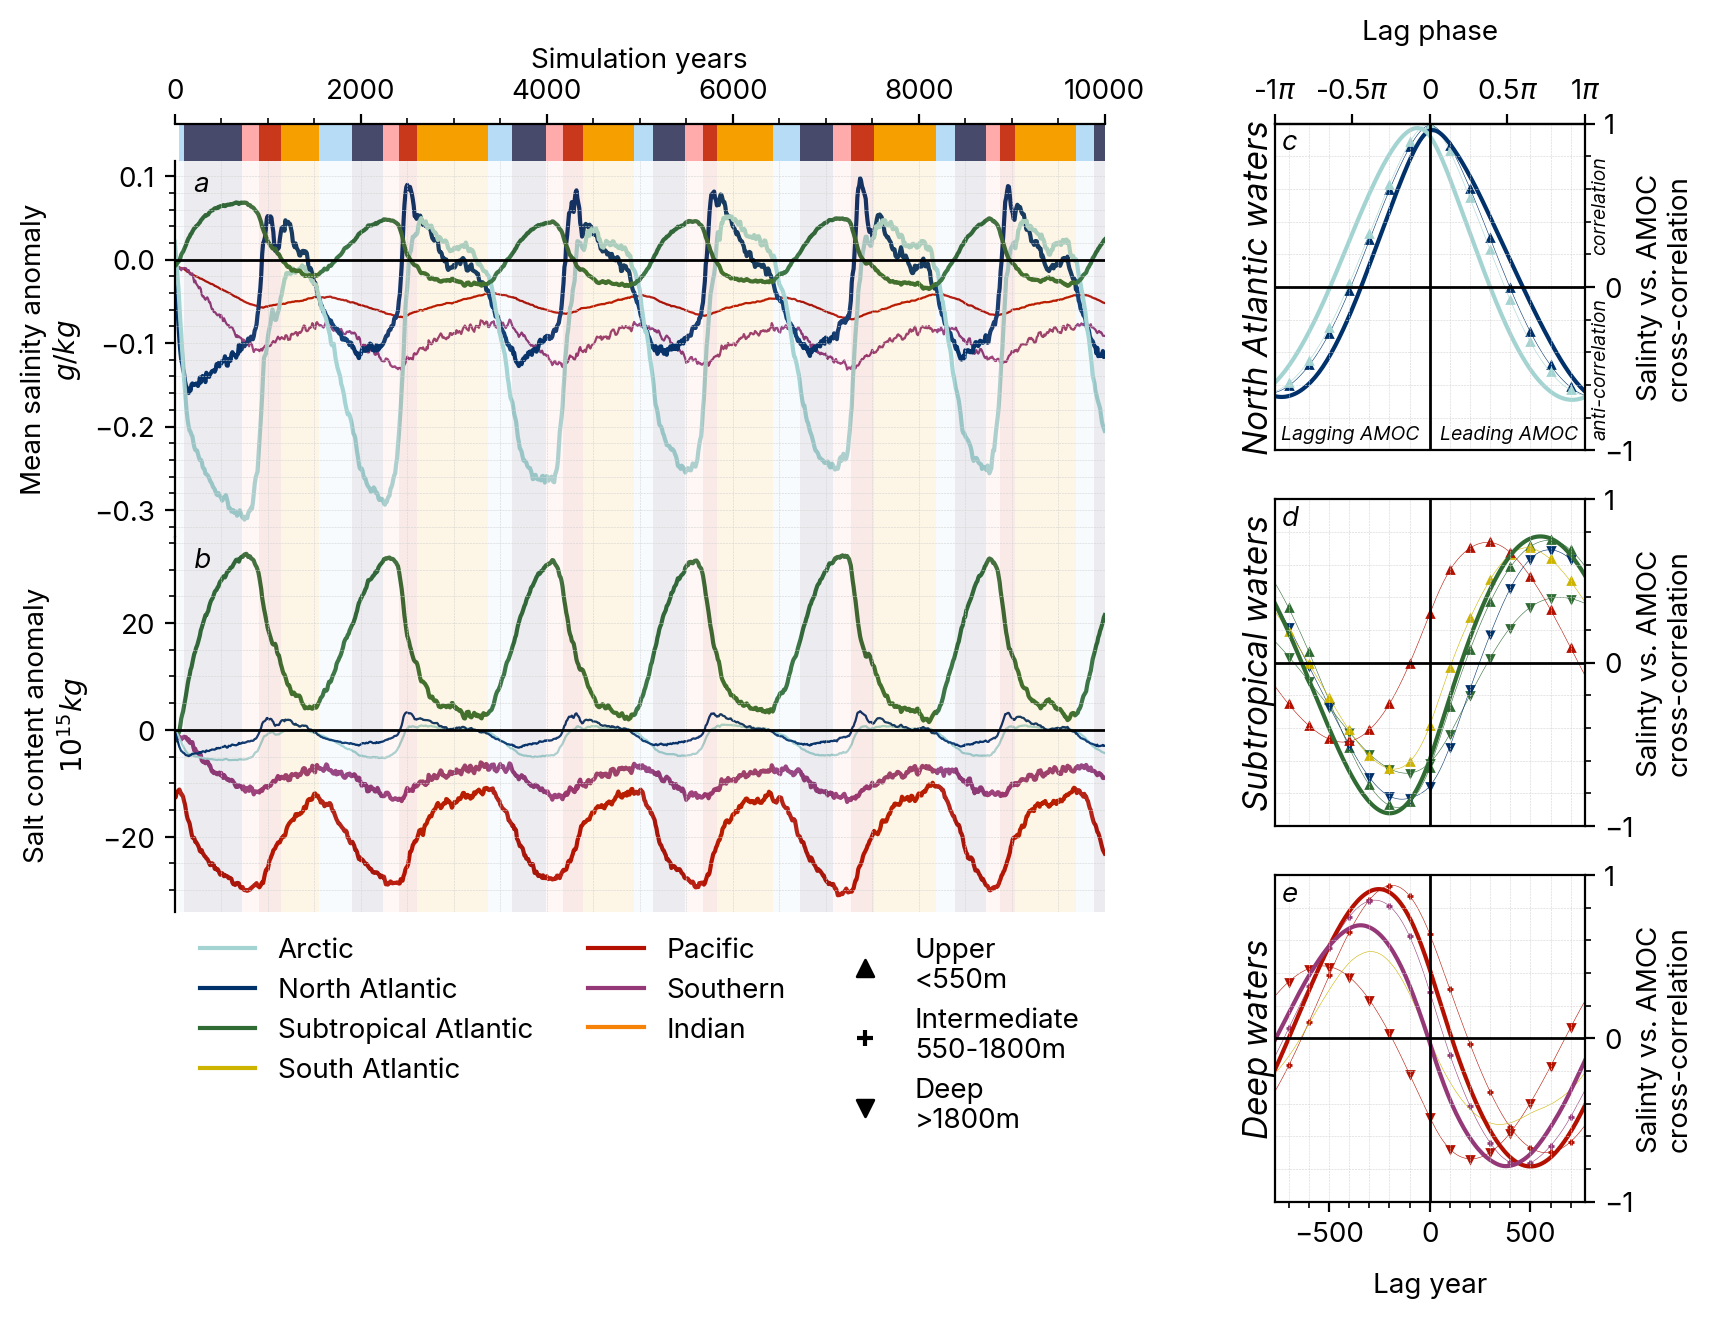

In [37]:
expt = 'tfgbi'

fig = plt.figure(figsize=(8, 7), dpi=200)

subfigs = fig.subfigures(1, 2, width_ratios=[3,1], wspace=0)

grid_left = subfigs[0].add_gridspec(2, 2, height_ratios=[3,1], hspace=0.05)

grid_sal = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_left[0,:], hspace=0, height_ratios=[1,10,10])

axSPAN = subfigs[0].add_subplot(grid_sal[0])
axMean = subfigs[0].add_subplot(grid_sal[1], sharex=axSPAN)
axBudget = subfigs[0].add_subplot(grid_sal[2], sharex=axSPAN)

# Grid clusters
grid_cluster = subfigs[1].add_gridspec(3, 1, hspace=0.15)
iterator = count(0)
axCC = {}

for cluster in ['sna', 'sta', 'dpc']:
    i = next(iterator)
    axCC[cluster] = subfigs[1].add_subplot(grid_cluster[i])
    
    
# Top top left - Plot span bar
for phase in spans[expt].keys():
    for span in spans[expt][phase]:
        axSPAN.axvspan(span[0], span[1], linewidth=0, color=color_spans[phase])
        
        
# Top left - Plot salintiy budget and mean anomalies

## Salinity Means
for zone in ['na','arc','tpa']:
    axMean.plot(salinity_means[expt].sel(zone=zone).sel(depth='tot').t.dt.year - 1000,
           (salinity_means[expt].sel(zone=zone).sel(depth='tot') \
            - np.mean(salinity_means['xoupa'].sel(zone=zone).sel(depth='tot'))), 
           color=color_zones[zone],lw=1.5,zorder=1)

for zone in ['pac','so']:
    axMean.plot(salinity_means[expt].sel(zone=zone).sel(depth='tot').t.dt.year - 1000,
           (salinity_means[expt].sel(zone=zone).sel(depth='tot') \
            - np.mean(salinity_means['xoupa'].sel(zone=zone).sel(depth='tot'))), 
           color=color_zones[zone],lw=0.8,zorder=0)


## Salinity Budget
for zone in ['tpa','pac','so']:
    axBudget.plot(salinity_clusters[expt].sel(zone=zone).sel(depth='tot').t.dt.year - 1000,
               (salinity_clusters[expt].sel(zone=zone).sel(depth='tot') \
                - np.mean(salinity_clusters['xoupa'].sel(zone=zone).sel(depth='tot')))*1e-15, 
               color=color_zones[zone],lw=1.5,zorder=1)

for zone in ['arc','na']:
    axBudget.plot(salinity_clusters[expt].sel(zone=zone).sel(depth='tot').t.dt.year - 1000,
               (salinity_clusters[expt].sel(zone=zone).sel(depth='tot') \
                - np.mean(salinity_clusters['xoupa'].sel(zone=zone).sel(depth='tot')))*1e-15, 
               color=color_zones[zone],lw=0.8,zorder=1)


    
# Bottom left - Mock time series for legends
lines, markers = [], []

for zone in masks.keys():
    lines.append(axMean.plot([],[],
            color=color_zones[zone],
            label=label_zones[zone])[0])

for marker in marker_depth.keys():
    if marker != 'tot':
        markers.append(axMean.scatter([],[],
                marker = marker_depth[marker], label=depth_label[marker],
                color='black'))


# Right - Plotting Cross correlation
for cluster in ['sna', 'sta', 'dpc']:

    ## Main clusters
    lw = 1.5
    markersize=6
    zorder=1
    for cluster_zone in primary_cluster[cluster]:
        zone, depth = cluster_zone[0], cluster_zone[1]
        axCC[cluster].plot(
            year_lags*10,
            cross_correlation[expt][zone][depth]*10,
            color=color_zones[zone], linewidth = lw, zorder=zorder
            )
        axCC[cluster].plot(
            year_lags[::10]*10,
            cross_correlation[expt][zone][depth][::10]*10,
            color=color_zones[zone], label=f"{label_zones[zone]} - {depth}", linewidth=0,
            marker=marker_depth[depth], markersize=markersize, zorder=zorder
        )

    ## Secondary clusters
    lw=0.2
    markersize=2
    zorder=0

    for cluster_zone in secondary_cluster[cluster]:
        zone, depth = cluster_zone[0], cluster_zone[1]
        axCC[cluster].plot(
            year_lags*10,
            cross_correlation[expt][zone][depth]*10,
            color=color_zones[zone], linewidth = lw, zorder=zorder
            )
        axCC[cluster].plot(
            year_lags[::10]*10,
            cross_correlation[expt][zone][depth][::10]*10,
            color=color_zones[zone], label=f"{label_zones[zone]} - {depth}", linewidth=0,
            marker=marker_depth[depth], markersize=markersize, zorder=zorder
        )
        
# Cross-corelations annotations
axCC['sna'].annotate('Lagging AMOC', xy=(0.02, 0.02), xycoords='axes fraction',
                      size=7, va='bottom', ha='left', style='italic')
axCC['sna'].annotate('Leading AMOC', xy=(0.98, 0.02), xycoords='axes fraction',
                      size=7, va='bottom', ha='right', style='italic')
axCC['sna'].annotate('correlation', xy=(1.05, 0.75), xycoords='axes fraction',
                      size=7, va='center', ha='center', style='italic', rotation=90)
axCC['sna'].annotate('anti-correlation', xy=(1.05, 0.25), xycoords='axes fraction',
                      size=7, va='center', ha='center', style='italic', rotation=90)

                
# Adding spans to time series 
for phase in spans[expt].keys():
    for span in spans[expt][phase]:
        axBudget.axvspan(span[0], span[1], alpha=0.1, linewidth=0, color=color_spans[phase])
        axMean.axvspan(span[0], span[1], alpha=0.1, linewidth=0, color=color_spans[phase])


# General parameters
for ax in np.concatenate([[axBudget, axMean], list(axCC.values())]) :
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.2)


# Spans parameters
axSPAN.set_xlabel("Simulation years")
axSPAN.xaxis.set_ticks_position('top')
axSPAN.xaxis.set_label_position('top')
axSPAN.yaxis.set_visible(False)
axSPAN.set_ylim([0,1])
axSPAN.set_xlim([0,10000])
for loc in ['left', 'right', 'bottom']:axSPAN.spines[loc].set_visible(False)

    
# Time series parameters
for ax in axBudget, axMean:
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['top', 'bottom', 'right']:ax.spines[loc].set_visible(False)
    ax.axhline(0, color='black', linewidth=1)
axBudget.set_ylabel(f"Salt content anomaly\n"r"$10^{15}kg$")
axMean.set_ylabel(f"Mean salinity anomaly\n"r"$g/kg$")

    
# Legend parameters
legend = axBudget.legend(handles=lines, fontsize="medium", bbox_to_anchor=(0,0), loc='upper left', frameon=False, ncol=2)
axBudget.add_artist(legend)
axBudget.legend(handles=markers, fontsize="medium", bbox_to_anchor=(1,0), loc='upper right', frameon=False)



# Phase parameters
for ax in list(axCC.values()):
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_xlim([-770,770])
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,0,1])
    ax.yaxis.set(ticks_position='right', label_position='right')
    ax.set_ylabel("Salinty vs. AMOC\ncross-correlation", labelpad=1)

secax = axCC['sna'].secondary_xaxis(
    'top',
    functions=(lambda yr : yr/1540*2*np.pi, lambda rad : rad*1540/(2*np.pi)))
secax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
secax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: r'{:.3g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
lbCC = secax.set_xlabel("Lag phase", labelpad=14)

for cluster in ['sna', 'sta']:
    axCC[cluster].tick_params(axis='x', colors='None', which='both')

for cluster in axCC.keys():
    axCC[cluster].annotate(cluster_name[cluster], xy=(-0.05,0.5), xycoords='axes fraction',
                           rotation = 90, ha='center', va='center',size='large', style='italic')
    
axCC['dpc'].set_xlabel("Lag year", labelpad=9)


# Annotations

axMean.annotate('a', xy=(0.02,0.92), xycoords='axes fraction', 
                size='medium', style='italic')
axBudget.annotate('b', xy=(0.02,0.92), xycoords='axes fraction',
                  size='medium', style='italic')
axCC['sna'].annotate('c', xy=(0.02,0.92), xycoords='axes fraction', 
                     size='medium', style='italic')
axCC['sta'].annotate('d', xy=(0.02,0.92), xycoords='axes fraction', 
                     size='medium', style='italic')
axCC['dpc'].annotate('e', xy=(0.02,0.92), xycoords='axes fraction', 
                     size='medium', style='italic')


In [38]:
# fig.savefig(f"{output_folder}/main/global.png", bbox_extra_artists=([lbCC]), bbox_inches='tight', format='png')
# fig.savefig(f"{output_folder}/main/global.pdf", bbox_extra_artists=([lbCC]), bbox_inches='tight', format='pdf')

## Figure 4 - Mechanism

See drawing

## Figure 5 - Comparison to non oscillating simulations

In [39]:
amoc_ts = {}
amocf_ts = {}

for expt in ['tfgbi', 'xouph', 'xoupf']:
    ts = xr.open_dataset(f"{data_folder}/{expt}/{expt}.merid.annual.nc")
    amoc_ts[expt] = ts.Merid_Atlantic.sel(latitude=26.5, method='nearest').max('depth').sortby('t')
    amocf_ts[expt] = filt.process(amoc_ts[expt].values)
    

In [40]:
mld_zone, mldf_zone = {}, {}

for expt in  ['tfgbi', 'xouph', 'xoupf']:
    mld_zone[expt], mldf_zone[expt] = {}, {}
    temp_mld = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.mld.zone_na.annual.nc").mld
    
    for zone in masks_na.keys():
        mld_zone[expt][zone] = temp_mld.sel(zone=zone)[1:]
        mldf_zone[expt][zone] = filt.process(mld_zone[expt][zone].values)

In [41]:
# Sea Ice

wice, sice = {}, {}

for expt in  ['tfgbi', 'xouph', 'xoupf']:

    wice[expt], sice[expt] = {}, {}
    ds_wice = xr.open_dataset(f"{data_folder}/{expt}/{expt}.iceconc.mr.nc").iceconc_mm_srf.isel(surface=0).sortby('t')
    ds_sice = xr.open_dataset(f"{data_folder}/{expt}/{expt}.iceconc.sp.nc").iceconc_mm_srf.isel(surface=0).sortby('t')

    for zone in masks_na_atm.keys():
        print(f"__Processing {zone}")
        wice[expt][zone] = (ds_wice*masks_na_atm[zone]).mean(
            dim=['longitude', 'latitude'])*100
        sice[expt][zone] = (ds_sice*masks_na_atm[zone]).mean(
            dim=['longitude', 'latitude'])*100


__Processing gin
__Processing irm
__Processing eur
__Processing gin
__Processing irm
__Processing eur
__Processing gin
__Processing irm
__Processing eur


In [42]:
salinity_clusters = {}

for expt in ['xoupa', 'tfgbi', 'xouph', 'xoupf']: 
    salinity_clusters[expt] = xr.open_dataset(f"{data_folder}/{expt}/salinity_budgets/{expt}.salinity_clusters.decadal.nc").salinity_cluster

In [43]:
ocnt, ocnd = {}, {}

for expt in ['tfgbi', 'xouph', 'xoupf']:
    print(f"__Processing {expt}")
    ocnt[expt] = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.oceantemppg.zone_na.annual.nc").temp_ym_dpth.sortby('t').dropna(dim='depth_1')
    ocnd[expt] = xr.open_dataset(f"{data_folder}/{expt}/na_variables/{expt}.oceandenspg.zone_na.annual.nc").density.sortby('t')


__Processing tfgbi
__Processing xouph
__Processing xoupf


In [44]:
N2 = {}

for expt in  ['tfgbi', 'xouph', 'xoupf']:
    N2[expt] = {}
    for zone in masks_na.keys():
        N2[expt][zone] = (-9.81/1025*ocnd[expt].sel(zone=zone).sel(
            depth_1=slice(0,1000)).diff(dim='depth_1', label='lower')\
                    /ocnd[expt].sel(zone=zone).sel(
            depth_1=slice(0,1000)).depth_1.diff(dim='depth_1', label='lower')).sum('depth_1')

In [45]:
cmap_amoc = LinearSegmentedColormap.from_list('magma', matplotlib.colormaps['magma'](np.linspace(0, 0.9, 256)))
                                              
def plot_LineCollection(ax, x, y, alpha, lw, cm):
    points = np.array([x, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cm, linewidth=lw, alpha=alpha)
    lc.set_array(y)

    ax.add_collection(lc)
    
color_wice = 'xkcd:dark teal'
color_sice = 'xkcd:brick red'


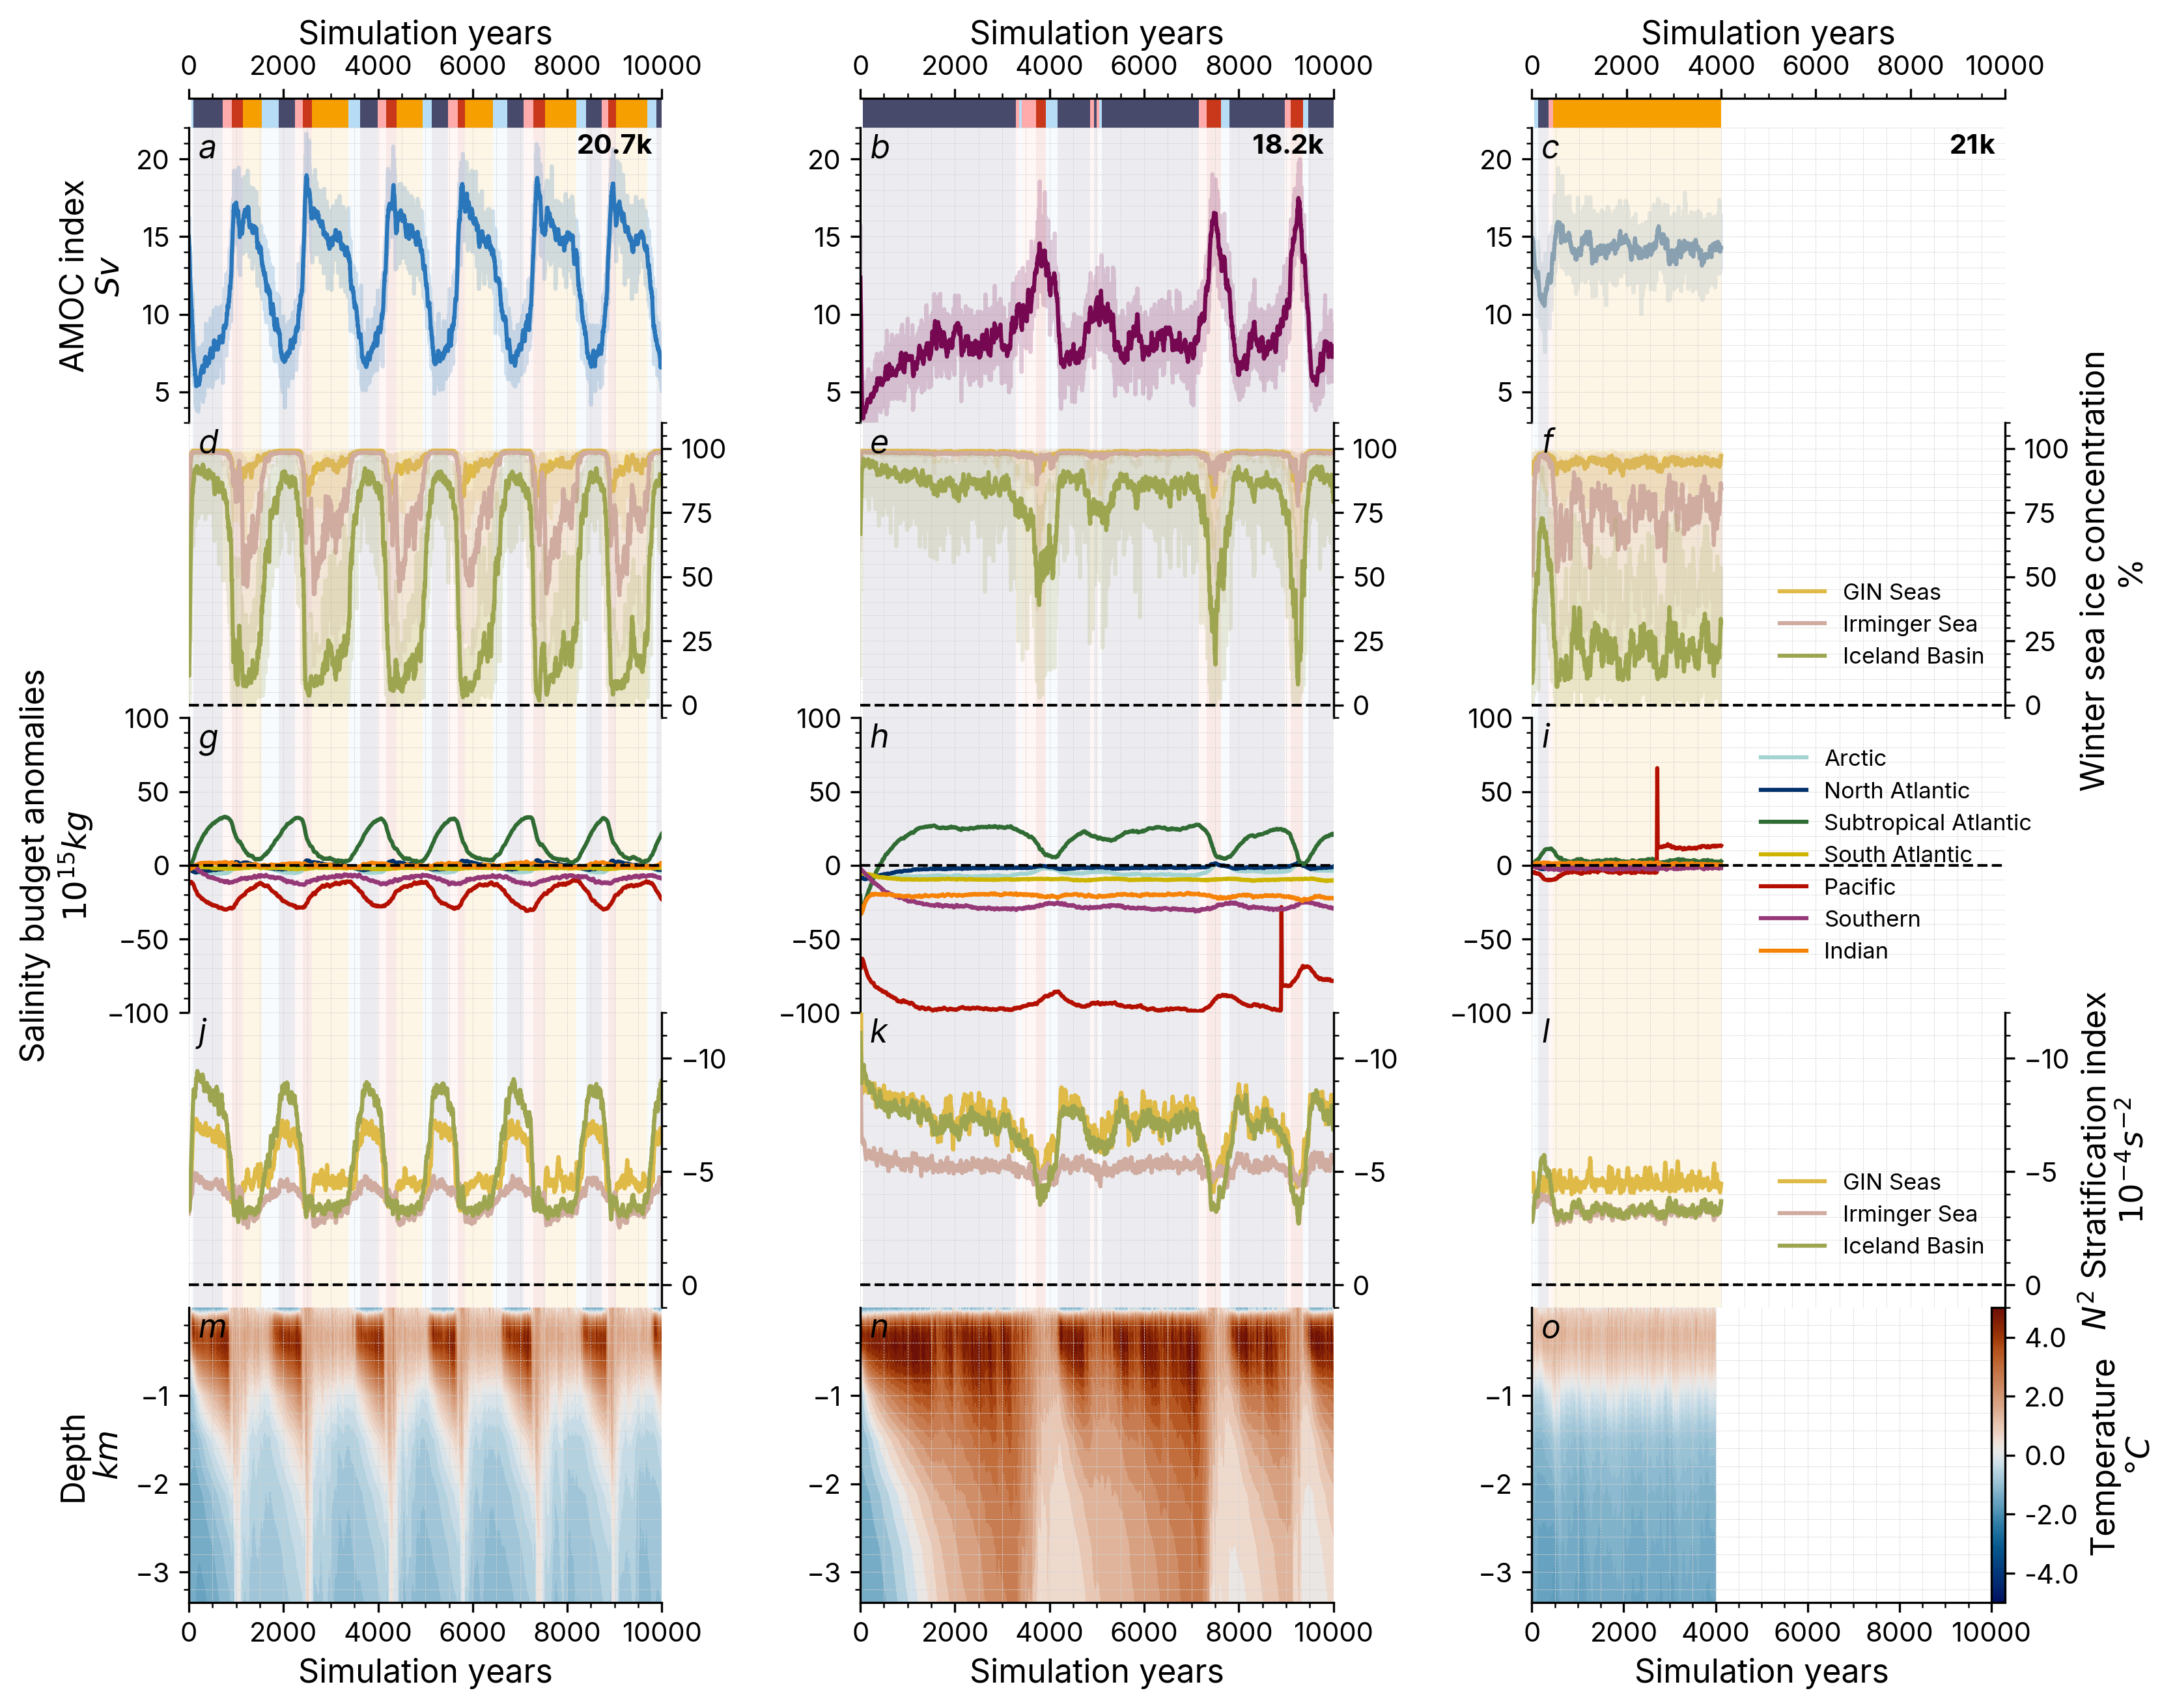

In [46]:
fig = plt.figure(figsize=(10, 10), dpi=300)

subfigs = fig.subfigures(1, 3,  wspace=0.1, facecolor='None')

axSPAN, axAMOC, axICE, axMLD, axS, axN2, axT = {}, {}, {}, {}, {}, {}, {}
axBuffer1, axBuffer2 = {}, {}

cmapT = LinearSegmentedColormap.from_list('vik', SCM.vik(np.linspace(0, 0.95, 256)))
cmT = {}
normT = TwoSlopeNorm(vmin=-5,vcenter=0,vmax=5)

iterator = count(0)

# Grids
for expt in ['tfgbi', 'xoupf', 'xouph']:
    i = next(iterator)

    grid = subfigs[i].add_gridspec(6, 1, height_ratios=[1,10,10,10,10,10], hspace=0)
    
    axSPAN[expt] = subfigs[i].add_subplot(grid[0])
    axAMOC[expt] = subfigs[i].add_subplot(grid[1], sharex=axSPAN[expt], facecolor='None')
    axICE[expt] = subfigs[i].add_subplot(grid[2], sharex=axSPAN[expt], facecolor='None')
    axS[expt] = subfigs[i].add_subplot(grid[3], sharex=axSPAN[expt], facecolor='None')
    axN2[expt] = subfigs[i].add_subplot(grid[4], sharex=axSPAN[expt], facecolor='None')
    axT[expt] = subfigs[i].add_subplot(grid[5], sharex=axSPAN[expt])
    # axMLD[expt] = subfigs[i].add_subplot(grid[6])

for expt in ['xoupf', 'xouph', 'xouph']:axN2[expt].sharey(axN2['tfgbi'])
for expt in ['xoupf', 'xouph', 'xouph']:axT[expt].sharey(axT['tfgbi'])

axTS = np.array([list(axAMOC.values()), list(axICE.values()), list(axS.values()), list(axN2.values()), list(axT.values())]).flat


# Plots
for expt in ['tfgbi', 'xoupf', 'xouph']:

    ## Plots spans
    for phase in spans[expt].keys():
        for span in spans[expt][phase]:
            axSPAN[expt].axvspan(span[0], span[1], alpha=1, linewidth=0, color=color_spans[phase])

    for ax in axAMOC[expt], axICE[expt], axS[expt], axN2[expt]:
        for phase in spans[expt].keys():
            for span in spans[expt][phase]:
                ax.axvspan(span[0], span[1], alpha=0.1, linewidth=0, color=color_spans[phase])

    ## Plot AMOC
    axAMOC[expt].plot(amoc_ts[expt].t.dt.year-1000, util.rmean(amoc_ts[expt],30), color=color_expts[expt])
    axAMOC[expt].plot(amoc_ts[expt].t.dt.year-1000, amoc_ts[expt], color=color_expts[expt], alpha=0.2)
    
    
    ## Sea ice
    for zone in ['gin', 'irm', 'eur']:

        axICE[expt].plot(wice[expt][zone].t.dt.year-1000, util.rmean(wice[expt][zone],30), color=color_zones[zone], label=label_zones[zone])
        axICE[expt].plot(wice[expt][zone].t.dt.year-1000, wice[expt][zone], color=color_zones[zone], alpha=0.2)

    
    ## Plot salinity clusters
    for zone in masks.keys():
        axS[expt].plot(salinity_clusters[expt].sel(zone=zone).sel(depth='tot').t.dt.year - 1000,
                 (salinity_clusters[expt].sel(zone=zone).sel(depth='tot') - 
                 np.mean(salinity_clusters['xoupa'].sel(zone=zone).sel(depth='tot').values))*1e-15, 
                  color=color_zones[zone], label=label_zones[zone])


    ## Plot N2 index
    for zone in ['gin', 'irm', 'eur']:
        axN2[expt].plot(N2[expt][zone].t.dt.year-1000, util.rmean(N2[expt][zone],30)*1e4, 
                        color=color_zones[zone], label=label_zones[zone])
        
    ## Plot Subsurface warming
    zone='gin'
    cmT[expt] = axT[expt].contourf(ocnt[expt].sel(zone=zone).t.dt.year-1000, -ocnt[expt].sel(zone=zone).depth_1/1000,
                        ocnt[expt].sel(zone=zone).transpose(), cmap=cmapT, norm=normT, levels=25, zorder=1)    
    

# Parameters

## General paramters
for ax in axTS:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.2, zorder=0)


## Span parameters
for ax in axSPAN.values():
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')    
    ax.yaxis.set_visible(False)
    for loc in ['left', 'right', 'bottom']:ax.spines[loc].set_visible(False)
    ax.set_xlim([0,10000])
    ax.set_xlabel("Simulation years", fontsize='large')

## AMOC parameters
for ax in axAMOC.values():
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['top', 'bottom', 'right']:ax.spines[loc].set_visible(False)
    ax.yaxis.set(ticks_position='left', label_position='left')
    ax.set_ylim([3,22])
axAMOC['tfgbi'].set_ylabel("AMOC index\n""$Sv$", fontsize='large')

## Sea ice parameters
for ax in axICE.values():
    ax.tick_params(axis='x', colors='None', which='both')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    for loc in ['top','left','bottom']:ax.spines[loc].set_visible(False)
    ax.yaxis.set(ticks_position='right', label_position='right')
    ax.set_ylim([-5,110])

axICE['xouph'].set_ylabel(r"Winter sea ice concentration""\n"r"%", fontsize='large')
axICE['xouph'].legend(loc='lower right', fontsize='small', bbox_to_anchor=(1, 0.1), frameon=False)    

## Salinity paramters
for ax in axS.values():
    ax.tick_params(axis='x', colors='None', which='both')
    for loc in ['top', 'bottom', 'right']:ax.spines[loc].set_visible(False)
    ax.axhline(0, color='black', lw=1, linestyle='--')
    ax.set_ylim([-100,100])

axS['tfgbi'].set_ylabel("Salinity budget anomalies\n"r"$10^{15}kg$", fontsize='large')
axS['xouph'].legend(loc='lower right', fontsize='small', bbox_to_anchor=(1.1, 0.1), frameon=False)    

## N2 paramters
for ax in axN2.values():
    ax.tick_params(axis='x', colors='None', which='both')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    for loc in ['top','left','bottom']:ax.spines[loc].set_visible(False)
    ax.yaxis.set(ticks_position='right', label_position='right')
    ax.set_ylim([1,-12])
    
axN2['xouph'].set_ylabel(r"$N^2$ Stratification index""\n"r"$10^{-4}s^{-2}$", fontsize='large')
axN2['xouph'].legend(loc='lower right', fontsize='small', bbox_to_anchor=(1, 0.1), frameon=False)    


# Hovmoller colorabars
fmt = lambda x, pos: '{:.1f}'.format(x)

cb = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=cmapT, norm=normT), cax=make_axes_locatable(axT['xouph']).append_axes(
    "right", size="3%", pad=0), format=FuncFormatter(fmt)).set_label("Temperature\n"r"$°C$", fontsize='large')

# Hovmoller parameter
for ax in axT.values(): 
    ax.set_xlabel("Simulation years", fontsize='large')
    for loc in ['top','right']:ax.spines[loc].set_visible(False)
    # ax.set_ylim([-4,0])


axT['tfgbi'].set_ylabel("Depth\n"r"$km$", fontsize='large')


# Annotations

## Experiment names
for expt in axAMOC.keys():
    txt = axAMOC[expt].annotate(f"{label_expts[expt]}", xy=(0.98, 0.98),
                                xycoords='axes fraction',
                                size='medium', va='top', ha='right', color='black', 
                                weight='bold')

## Labels
i = count(0)
for ax in np.array([list(axAMOC.values()), list(axICE.values()), list(axS.values()), list(axN2.values()), list(axT.values())]).flat:
    label = alc[next(i)]
    ax.annotate(label, xy=(0.02,0.9), xycoords='axes fraction',
                         size=12, style='italic')


In [47]:
# fig.savefig(f"{output_folder}/main/comparison.png", bbox_extra_artists=(), bbox_inches='tight', format='png')
# fig.savefig(f"{output_folder}/main/comparison.pdf", bbox_extra_artists=(), bbox_inches='tight', format='pdf')